# 비즈니스 기대가치 평가 : Semiconductor manufacturing process 



## 0.환경준비

### 0.1 라이브러리 로딩

In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.backend import clear_session

### 0.2 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [ ]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)
    
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y})
    error_df = error_df.reset_index()

    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    cm = confusion_matrix(y, pred_temp)
    print('< confusion matrix >\n')
    print(cm)
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return cm

## 1.데이터 준비

* 데이터 로딩

In [ ]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,v121,v157,v222,v223,v224,v249,v250,v251,v252,v253,v255,v256,v292,v360,v361,v362,v387,v388,v389,v390,v391,v393,v394,v430,v494,v495,v496,v521,v522,v523,v524,v525,v527,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,6.3788,0.0506,0.0707,0.0211,175.2173,0.0188,0.0,219.9453,0.0011,2.8374,0.0050,0.4269,0.0167,0.0229,0.0065,55.2039,0.0055,0.0,61.5932,0.0003,0.9967,0.0017,0.1437,3.6084,2.9570,2.1739,10.0261,1.9864,0.0,29.3804,0.1094,4.8560,0.5064,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,6.5061,0.0437,0.0761,0.0014,128.4285,0.0154,0.0,193.0287,0.0007,3.8999,0.0086,0.5749,0.0139,0.0248,0.0005,46.3453,0.0049,0.0,65.0999,0.0002,1.1655,0.0027,0.1921,3.1595,3.2029,0.1441,6.6487,1.6292,0.0,26.3970,0.0673,6.6475,0.8832,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,6.4527,0.0497,0.0963,0.0152,182.4956,0.0273,0.0,104.4042,0.0007,4.1446,0.0063,0.4166,0.0167,0.0302,0.0046,58.0575,0.0100,0.0,28.7334,0.0003,1.2356,0.0020,0.1375,3.5220,3.9238,1.5357,10.8251,2.9626,0.0,14.5293,0.0751,7.0870,0.6451,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,6.4935,0.0699,0.0764,0.0015,152.0885,0.0234,0.0,94.0954,0.0010,3.2119,0.0072,0.4212,0.0245,0.0252,0.0004,45.7058,0.0068,0.0,32.4228,0.0003,1.1135,0.0023,0.1348,4.9898,3.1817,0.1488,8.6804,2.4416,0.0,13.2699,0.0977,5.4751,0.7404,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,6.3551,0.0538,0.0802,0.0004,69.1510,0.0240,0.0,149.2172,0.0006,2.5775,0.0214,0.4051,0.0181,0.0286,0.0001,21.0312,0.0089,0.0,57.2692,0.0002,0.8495,0.0077,0.1356,3.8754,3.2712,0.0372,3.7821,2.5512,0.0,18.7319,0.0616,4.4146,2.2181,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [ ]:
target = 'label'

In [ ]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [ ]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable

* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [ ]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


* 스케일링(Optional) 
    * 스케일링을 필요로 하는 알고리즘이 있습니다. 
    * SVM은 스케일링을 필요로 합니다.

In [ ]:
scaler = StandardScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

* 1C-SVM, AE를 위한 학습용 데이터 준비

In [ ]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train_s[y_train == 0]

## 2.모델링

* 앞에서 실습한 코드를 붙여 놓고 실행하시오.
* 각 모델의 confusion matrix를 저장하시오.

### 2.1 Class weight 조정 모델

In [ ]:
model = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model.fit(x_train, y_train)
pred = model.predict(x_val)

cw_cm = confusion_matrix(y_val, pred)

### 2.2 Isolation Forest 모델 


In [ ]:
model = IsolationForest(contamination=0.066)
model.fit(x_train)
pred = model.predict(x_val)
pred = np.where(pred == 1, 0, 1)

if_cm = confusion_matrix(y_val, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


### 2.3 One Class SVM 모델 


In [ ]:
model = OneClassSVM()
model.fit(x_train0)
pred = model.predict(x_val_s)
pred = np.where(pred == 1, 0, 1)

oc_cm = confusion_matrix(y_val, pred)

### 2.4 Auto Encoder 모델 


* 간단한 hyper parameter 설정

In [ ]:
epochs = 100
batch_size = 64
input_dim = x_train0.shape[1] #num of columns
input_dim

52

* 모델 설계

In [ ]:
clear_session()

input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

# Decoder
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

* compile + 학습

In [ ]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_val_s, x_val_s)).history

* 예측 및 Reconstruction Error 계산

In [ ]:
pred = autoencoder.predict(x_val_s)

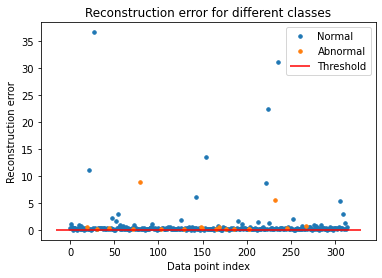

In [ ]:
result = recon_err_plot(x_val_s, pred, y_val, .1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


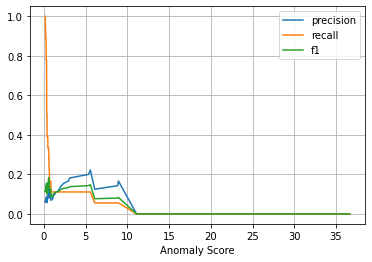

In [ ]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['True_class'], result['Reconstruction_error'])

In [ ]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.5767513870722548

In [ ]:
# confusion matrix 저장하기
ae_cm = classification_report2(result['True_class'], result['Reconstruction_error'],thres_f1_max)

< confusion matrix >

[[255  41]
 [ 13   5]]


< classification_report >

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       296
           1       0.11      0.28      0.16        18

    accuracy                           0.83       314
   macro avg       0.53      0.57      0.53       314
weighted avg       0.90      0.83      0.86       314



## 3.비즈니스 평가

비용 구조는 다음과 같습니다.
* 현 공정에서 발견된 불량의 비용은 1개당 6000원
* 현 공정에서 찾이 못한 불량이 다음 공정에서 발견되면, 1개당 16000원 비용 발생
* 만약 불량이 아닌데, 불량으로 잘못 판정할 경우 검사비용이 1개당 800원 발생

* 비즈니스 기대가치 매트릭스

In [ ]:
bv = np.array([[0,800],[16000, 6000]])
bv

array([[    0,   800],
       [16000,  6000]])

* confusion matrix를 비율로 변환 

In [ ]:
cw_p = cw_cm / np.sum(cw_cm)

In [ ]:
if_p = if_cm / np.sum(if_cm)

In [ ]:
oc_p = oc_cm / np.sum(oc_cm)

In [ ]:
ae_p = ae_cm / np.sum(ae_cm)

* 비즈니스 가치로 환산 

> 아래 결과는 개당 비용으로 환산한 것입니다.  
가장 낮은 비용의 모델이 가장 목적에 부합된 모델입니다.

In [ ]:
print('Class weight'.ljust(18), np.sum(cw_p * bv))
print('Isolation Forest'.ljust(18), np.sum(if_p * bv))
print('One Class SVM'.ljust(18), np.sum(oc_p * bv))
print('AutoEncoder'.ljust(18), np.sum(ae_p * bv))

Class weight       894.267515923567
Isolation Forest   872.6114649681529
One Class SVM      991.0828025477707
AutoEncoder        862.4203821656051
